# 임베딩 간 거리를 토대로 유명인과 닮은 정도 판단하기
## : 임베딩 평균 벡터 도입으로 일반화 능력 개선하기

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 유명인 얼굴 이미지로부터 임베딩을 구하여 내 이미지와 임베딩 벡터 간의 거리를 토대로 닮은 인원을 도출하는 예제를 진행하였다. 이미지 데이터는 60인의 유명인 총 641장이며, 2인 이상의 이미지, 얼굴이 검출되지 않는 이미지를 필터링하여 최종적으로 60인에 대한 456개의 이미지를 사용하였다. 비교할 이미지로는 'lena.png'를 사용하였다. 벡터 간 거리를 계산하기 위해 L2 Norm을 사용하였다. 유명인 별로 임베딩 벡터의 평균을 구하여 대표 벡터로 사용한 후 이를 lena.png의 임베딩 벡터와 비교하여 닮은 유명은 5인을 선정하였다. 이후 선정된 유명인의 이미지 중에서 거리가 가까운 이미지를 선정하였다. 그 결과 Meg Ryan '2.png'의 거리는 0.497로 가장 가까웠으며, Sarah Chalke '69.png', Julia Roberts 175.png' 외 2인은 0.609, 0.626, ...(생략) 순의 거리에 있음을 확인하였다.
</span>

***

<br><br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 60인의 유명인 얼굴 이미지를 바탕으로 임베딩을 추출하고 임베딩 간 거리를 '닮은 정도'의 기준으로 하여 새로운 이미지를 입력하였을 때, 가장 닮은 유명인의 이름과 그 거리를 반환하는 과정을 진행할 것입니다. 또한, 유명인 별로 임베딩들의 평균을 구하여 각 유명인을 대표하는 새로운 임베딩 벡터를 만들고 이를 토대로 닮은 정도를 판단할 예정입니다. 예제의 진행 순서는 다음과 같습니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 임베딩 간 거리를 토대로 닮은 정도 파악하기_
>
> _4. 내 이미지 입력하여 닮은 유명인 출력하기_

***

#### 라이브러리와 자주 사용되는 함수 불러오기

In [1]:
import os   #디렉토리 관리
import cv2   #이미지 처리
import dlib   #얼굴 검출
import numpy as np   #행렬 처리
import seaborn as sns   #이미지 시각화
import pandas as pd   #데이터프레임
import face_recognition   #얼굴 검출 및 크롭
from sklearn.manifold import TSNE   #tsne 차원축소
import matplotlib.pyplot as plt   #이미지 시각화
from mpl_toolkits.mplot3d import Axes3D   #3D 시각화
from sklearn.decomposition import PCA   #주성분 분석
from sklearn.preprocessing import StandardScaler   #정규화
from matplotlib.offsetbox import OffsetImage, AnnotationBbox   #이미지 시각화

In [2]:
#이미지 load 함수=========================
def img_load(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
#End======================================


#이미지 리스트화 함수=====================
def get_img_data(path):   #디렉토리로부터 이미지를 가져와 반환하는 함수
    img_names = os.listdir(path)
    return_img = []
    for img_name in img_names:
        img = img_load(path + "/" + img_name)
        
        w, h, _ = img.shape   #이미지 사이즈 취득
        new_size = int(w * 250 / h)
        img = cv2.resize(img, (250, new_size))   #height 비율에 맞춰 사이즈 조정
        
        return_img.append(img) 
    return return_img
#End======================================


#이미지 시각화 함수=======================
def show_img_list(img_list):
    paper = len(img_list)
    if paper % 2 == 0:
        row, col = 2, int(paper / 2)
    else:
        row, col = 1, paper
        
    plt.figure(figsize=(15, 7))
    for idx, img in enumerate(img_list):
        plt.subplot(row, col, idx + 1)
        plt.title("IMAGE " + str(idx))
        plt.imshow(img)
        plt.axis("off")
    plt.show()
    return
#End======================================

<br><br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용한 데이터는 60인의 유명인 사진 640장과 CV에서 자주 사용되는 'lena.png'입니다. 유명인 사진 데이터셋은 'Columbia University'에서 제공한 'PubFig: Public Figures Face Database'을 이용하였습니다. 유명인은 'Anna Paquin', 'Zac Efron', 'Jared Leto' 등으로 각 유명인 별로 하나 이상의 이미지가 존재합니다. 아래는 유명인 사진 샘플과 데이터 정보를 간략화한 것을 보여줍니다.
</span>

***

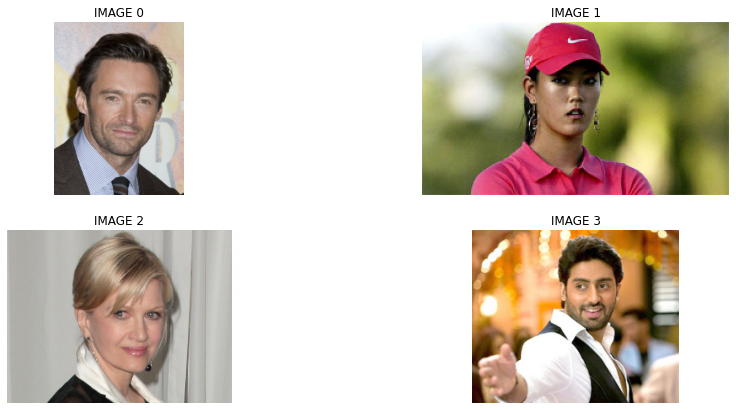

In [3]:
sample= get_img_data("./face_img/sample/")
show_img_list(sample)

In [4]:
#셀럽 이름 및 이미지 장수
dataset_dir = "./face_img/dataset/"

print("*" * 35)
total_img = 0
for idx, name in enumerate(os.listdir(dataset_dir)):
    num = len(os.listdir(dataset_dir + name + "/"))
    total_img += num
    print("{0}: {1}".format(name, num))
    if idx >= 10:
        print("......(skip)")
        break
print("*" * 35)

print("=" * 35)
print("total celeb num:", len(os.listdir(dataset_dir)))
print("total img num:", total_img)
print("=" * 35, end="\n\n")

***********************************
Anna Paquin: 27
Zac Efron: 78
Jared Leto: 64
Mickey Rourke: 66
Danny Devito: 22
Audrey Tautou: 37
Cristiano Ronaldo: 95
Kiefer Sutherland: 81
Julia Roberts: 107
Ali Landry: 19
Steve Martin: 45
......(skip)
***********************************
total celeb num: 60
total img num: 641



#### 이미지 데이터셋 출처
***
+ "PubFig: Public Figures Face Database", Columbia University, last modified, , acessed Sep, 14, 2021, https://www.cs.columbia.edu/CAVE/databases/pubfig/


+ "Miscellaneous", USCviterbi, last modified, , accessed Sep, 30, 2021, http://sipi.usc.edu/database/database.php?volume=misc&image=12
***

<br><br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터셋에는 다양한 형태의 이미지가 존재합니다. 유명인 뿐만 아니라 다른 인물도 함께 나온 이미지, 때로는 유명인을 구별하기 힘든 이미지가 있기도 합니다. 따라서 데이터 전처리 단계에서는 데이터셋의 이미지로부터 2개 이상의 얼굴이 검출되는 이미지와 얼굴이 검출되지 않는 이미지를 제외하고자 합니다. 또한, 우리는 얼굴 이미지로부터 임베딩을 구해야하기 때문에 얼굴 부분을 크롭하는 것까지 하여 데이터셋을 전처리 할 것입니다.
</span>

***

### 3.1 2인 이상 이미지 제외하기
***
+ 2인 이상 이미지를 검출하기위해 dlib 라이브러리의 `get_frontal_face_detector()`을 이용하였습니다.
+ `get_face_num` 함수는 이미지를 입력하면 검출된 얼굴의 수를 반환합니다.
***

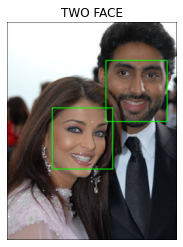

***********************************
face num: 2
***********************************


In [5]:
detector_hog = dlib.get_frontal_face_detector()
#얼굴 검출 개수 반환 함수=========
def get_face_num(img):
    dlib_rects = detector_hog(img, 1)
    return len(dlib_rects)
#End==============================


#이미지 출력=======================
img = img_load("./face_img/dataset/Abhishek Bachan/1.png")

dlib_rects = detector_hog(img, 1)
for dlib_rect in dlib_rects:
    x_1, y_1 = dlib_rect.left(), dlib_rect.top()
    x_2, y_2 = dlib_rect.right(), dlib_rect.bottom()
    cv2.rectangle(img, (x_1, y_1), (x_2, y_2), (0,255,0), 1, lineType=cv2.LINE_AA)

plt.imshow(img)
plt.axis('off')
plt.title("TWO FACE")
plt.show()
#End================================


print("*" * 35)
print("face num: {0}".format(get_face_num(img)))
print("*" * 35)

<br>

### 3.2 얼굴 크롭하기
***
+ `get_cropp_face` 함수는 이미지를 입력하면 얼굴부분을 검출하여 크롭한 이미지를 반환합니다.
***

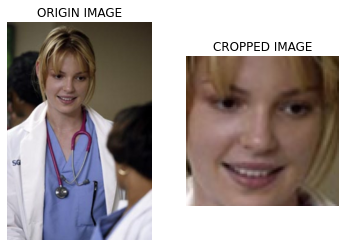

In [6]:
#얼굴 크롭 함수=====================
def get_cropp_face(img):
    face_locations = face_recognition.face_locations(img)
    y1, x2, y2, x1 = face_locations[0]   #좌표
    cropped_face = img[y1-5:y2+5, x1-5:x2+5,:]   #크롭
    return cropped_face
#End================================


#이미지 시각화======================
img = img_load("./face_img/dataset/Katherine Heigl/12.png")
cropp_img = get_cropp_face(img)

for idx, data in enumerate([[img, "ORIGIN IMAGE"], [cropp_img, "CROPPED IMAGE"]]):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(data[0])
    plt.axis('off')
    plt.title(data[1])
plt.show()
#End================================

<br><br>

## 4. 임베딩 간 거리를 바탕으로 닮은 정도 판단하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 전처리 단계를 통하여 이미지로부터 얼굴 부분만 크롭하여 이미지를 얻을 수 있었습니다. 이제 해당 이미지를 바탕으로 임베딩 벡터를 획득하고 임베딩 벡터 간의 거리를 구하는 방법을 설명하고자 합니다.
</span>

***

### 4.1 얼굴 임베딩 획득
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 얼굴 임베딩 벡터는 dlib 라이브러리의 'face_recognition.face_encodings()'를 통하여 획득할 수 있습니다. 또한, 임베딩은 128 크기의 벡터에 해당합니다. 아래는 이미지와 그에 대한 임베딩 벡터를 보여줍니다.
</span>

***

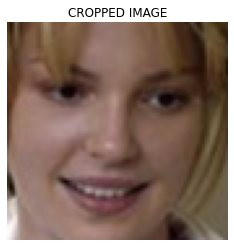

		IMAGE ===> embedding
↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

[-0.246  0.031 -0.052 -0.063 -0.125 -0.043  0.006 -0.085  0.208 -0.137
  0.178 -0.117 -0.309 -0.023 -0.097  0.282 -0.153 -0.178 -0.079 -0.065
  0.091  0.038 -0.016  0.143 -0.106 -0.235 -0.066 -0.049 -0.074 -0.04
  0.073  0.187 -0.109 -0.001  0.031  0.202  0.008 -0.109  0.197 -0.019
 -0.242 -0.096  0.126  0.302  0.156 -0.046 -0.017 -0.112  0.12  -0.39
 -0.005  0.136  0.03   0.126  0.056 -0.208  0.113  0.162 -0.211 -0.014
  0.056 -0.115  0.006 -0.103  0.215  0.153 -0.152 -0.114  0.219 -0.16
 -0.064  0.124 -0.09  -0.248 -0.3    0.002  0.409  0.172 -0.12   0.072
 -0.019 -0.023  0.033  0.103 -0.013 -0.061 -0.165 -0.02   0.231 -0.035
  0.017  0.273  0.087 -0.073  0.066  0.18  -0.062 -0.004 -0.146  0.01
  0.016 -0.154 -0.023  0.004 -0.162  0.196  0.001 -0.007 -0.107 -0.056
 -0.069  0.092  0.172 -0.224  0.166  0.115  0.038  0.255  0.071  0.189
 -0.053 -0.13  -0.106 -0.113  0.052  0.006  0.014  0.121]

***********************************
embeddi

In [7]:
#임베딩 획득 함수===================
def get_embedding(face_img):
    return face_recognition.face_encodings(face_img)
#End================================


#입력 이미지 임베딩 구하기 함수============
def get_embedding_raw_img(img):
    face_num = get_face_num(img)
    if face_num != 1:
        print("face num is over one")
        return None
        
    cropp_img = get_cropp_face(img)   #얼굴 크롭
    emb = get_embedding(cropp_img)   #임베딩 획득

    if not emb:   #임베딩 획득 실패 시 제외
        print("can't get embedding vlaue")
        return None
    return emb[0].tolist()
#End========================================


#이미지 시각화======================
plt.imshow(cropp_img)
plt.axis('off')
plt.title("CROPPED IMAGE")
plt.show()
#End================================


print("\t\tIMAGE ===> embedding")
print("↓" * 25, end="\n\n")

emb = np.array(get_embedding_raw_img(img)).round(3)
print(emb, end="\n\n")

print("*" * 35)
print("embedding size: {0}".format(emb.shape))
print("*" * 35)

<br>

### 4.2 임베딩 간의 거리 비교하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 우리는 이제 이미지로부터 임베딩 벡터를 구할 수 있습니다. 이제 임베딩 벡터 간의 거리를 구해야 하는데, 이는 L1 또는 L2 Norm을 이용합니다. 본 예제에서는 L2 노름을 이용하였습니다. 'get_distance' 함수는 두 임베딩 벡터를 입력하면 L2 Norm을 기반으로 그 거리를 반환하여줍니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 아래는 유명인 'Ben Stiller'의 두 이미지 『Ben Stiller 35.png』, 『Ben Stiller 81.png』 그리고 'Mark Ruffalo'의 이미지  『Mark Ruffalo 21.png』의 임베딩 벡터 거리를 제시한 것입니다. 본 예제에서 만든 함수인 'get_distance'을 이용하였습니다. 그 결과 『Ben Stiller 35.png』와 『Ben Stiller 81.png』의 거리는 0.413이었으며, 『Ben Stiller 35.png』와 『Mark Ruffalo 21.png』의 거리는 0.789이었습니다. 따라서, 동일 인물 사진의 거리를 가깝다고 하였으니 올바르게 인식한 것으로 이해할 수 있습니다.
</span>

***

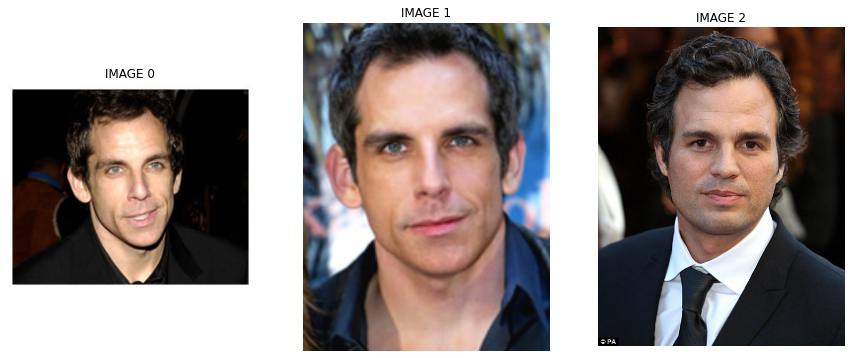




**************************************************
between 『Ben Stiller 35.png』 and 『Ben Stiller 81.png』: 0.413

between 『Ben Stiller 35.png』 and 『Mark Ruffalo 21.png』: 0.789
**************************************************


In [8]:
#임베딩 거리 구하기 함수============
def get_distance(emb1, emb2):
    emb1, emb2 = np.array(emb1), np.array(emb2)
    distances = np.linalg.norm([emb1 - emb2], axis=1, ord=2)
    return distances[0]
#End================================


bs1_img = img_load("./face_img/dataset/Ben Stiller/35.png")
bs2_img = img_load("./face_img/dataset/Ben Stiller/81.png")
mr1_img = img_load("./face_img/dataset/Mark Ruffalo/21.png")
show_img_list([bs1_img, bs2_img, mr1_img])

bs1_emb = get_embedding_raw_img(bs1_img)
bs2_emb = get_embedding_raw_img(bs2_img)
mr1_emb = get_embedding_raw_img(mr1_img)

print("\n\n\n" + "*" * 50)
print(
    "between 『Ben Stiller 35.png』 and 『Ben Stiller 81.png』: {0}".format(
        round(get_distance(bs1_emb, bs2_emb), 3)
    ), end="\n\n"
)

print(
    "between 『Ben Stiller 35.png』 and 『Mark Ruffalo 21.png』: {0}".format(
        round(get_distance(bs1_emb, mr1_emb), 3)
    )
)
print("*" * 50)

<br>

### 4.3 차원 축소를 통한 데이터 시각화 하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이미지로부터 추출한 임베딩 벡터의 크기는 128입니다. 이를 보기 편하게 시각화 하기 위해서는 2 ~ 3차원으로 차원을 축소할 필요가 있습니다. 이를 위해 PCA를 사용하여 임베딩 벡터를 2차원으로 축소한 후 시각화 하고자 합니다. PCA는 스킷런 라이브러리에서 제공하는 것을 이용하였습니다. &lt;Fig. 1>은 『Ben Stiller 35.png』, 『Ben Stiller 81.png』, 『Mark Ruffalo 21.png』 이미지의 임베딩 벡터를 PCA를 사용하여 2차원으로 축소한 후 시각화 한 것입니다. 동일 인물 간 거리가 가까운 것을 확인할 수 있습니다.
</span>

***

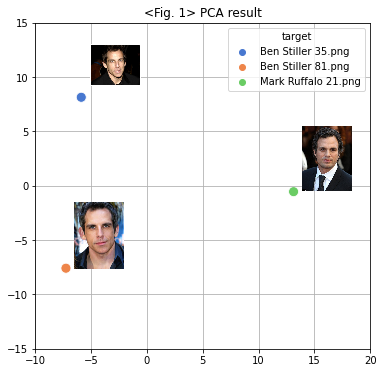

**************************************************
           0         1               target
0  -5.883961  8.135028   Ben Stiller 35.png
1  -7.256509 -7.587608   Ben Stiller 81.png
2  13.140470 -0.547420  Mark Ruffalo 21.png
**************************************************


In [9]:
#차원 축소 함수======================
def get_PCA(x, y, dim):
    scaler = StandardScaler()
    result = scaler.fit_transform(x)
    data_scaled = pd.DataFrame(result)

    pca = PCA(n_components=dim)
    result = pca.fit_transform(data_scaled)
    result = pd.DataFrame(result)
    result["target"] = y
    return result
#End==================================


#get PCA==============================
img_list = [bs1_img, bs2_img, mr1_img]
emb_list = [bs1_emb, bs2_emb, mr1_emb]
Y = ["Ben Stiller 35.png", "Ben Stiller 81.png", "Mark Ruffalo 21.png"]

pca = get_PCA(emb_list, Y, 2)
#End==================================


#차원 축소 시각화=====================
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("<Fig. 1> PCA result")

ax.set_xlim([-10, 20])
ax.set_ylim([-15, 15])

sns.scatterplot(x=pca[0], y=pca[1], hue=pca["target"], s=100, palette=sns.color_palette('muted', n_colors=3))

for img, (_, row) in zip(img_list, pca.iterrows()):
    imagebox = OffsetImage(img, zoom = 0.2)
    ab = AnnotationBbox(imagebox, (row[0]+3, row[1]+3), frameon = False)
    ax.add_artist(ab)
    
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

plt.show()
#End==================================


print("*" * 50)
print(pca)
print("*" * 50)

<br><br>

### 4.4 유명인 별 임베딩 저장하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이제 각 유명인의 이미지로부터 전처리하고 임베딩을 추출하여 이를 기록하는 하나의 '책'을 만들고자 합니다. 얼굴의 임베딩 벡터를 기록하는 책이니 'Face book'으로 명명하고 책을 먼저 만든 후, 임베딩을 기록하겠습니다.
</span>

***

#### FaceBook 클래스 생성
***
+ `Push_face()` 함수는 유명인의 이름과 파일 이름, 임베딩을 입력하여 기록하는 것 입니다.
+ `get_embadding()` 함수는 유명인의 이름과 파일 이름을 입력하면 임베딩을 반환 합니다.
+ `get_book()` 함수는 임베딩 북 전체를 반환 합니다.
***

In [10]:
class FaceBook:
    def __init__(self):
        self.emb_book = {}
        self.file_idx_book = {}
        
    def push_face(self, name, file_idx, emb):
        if type(emb) is not list:
            emb = emb.tolist()
        if name in self.file_idx_book.keys():   #이름이 있을 때
            if not emb in self.emb_book[name]:   #중복 emb 제외
                self.emb_book[name] += [emb]
                self.file_idx_book[name] += [file_idx]
        else:   #이름이 없을 때,
            self.emb_book[name] = [emb]
            self.file_idx_book[name] = [file_idx]
    
    def get_embadding(self, name, file_name):
        idx = facebook.file_idx_book[name].index(file_name)
        embedding = facebook.emb_book[name][idx]
        return embedding
    
    def get_book(self):
        return [self.emb_book.copy(), self.file_idx_book.copy()]

<br>

#### 모든 셀럽 임베딩 등록하기
***
+ 60명의 유명인의 이미지를 전처리하고 facebook에 임베딩을 기록하는 과정을 거칩니다.
***

In [11]:
facebook = FaceBook()   #페이스북 생성
dataset_dir = "./face_img/dataset/"

print("*" * 35)
for idx, name in enumerate(os.listdir(dataset_dir)):
    for img_file in os.listdir(dataset_dir + name):
        img_path = dataset_dir + name + "/" + img_file
        img = cv2.imread(img_path)   #이미지 호출
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   #이미지 RGB 전환
        
        face_num = get_face_num(img)   #이미지 검출 얼굴 수
        if face_num != 1: continue;   #0명 혹은 2명 이상 검출 이미지 제외
        
        cropp_img = get_cropp_face(img)   #얼굴 크롭
        emb = get_embedding(cropp_img)   #임베딩 획득
        
        if not emb: continue;   #임베딩 획득 실패 시 제외
        emb = emb[0]
        facebook.push_face(name, img_file, emb)
    
    if idx % 5 == 0:
        rate = round(idx / len(os.listdir(dataset_dir)) * 100, 2)
        print("{0} / {1}: {2}%".format(idx, len(os.listdir(dataset_dir)), rate))
print("*" * 35)

***********************************
0 / 60: 0.0%
5 / 60: 8.33%
10 / 60: 16.67%
15 / 60: 25.0%
20 / 60: 33.33%
25 / 60: 41.67%
30 / 60: 50.0%
35 / 60: 58.33%
40 / 60: 66.67%
45 / 60: 75.0%
50 / 60: 83.33%
55 / 60: 91.67%
***********************************


#### facebook에 기록된 데이터 정보
***
+ 60명의 유명인에 대한 456개의임베딩 데이터가 기록된 것을 확인 할 수 있습니다.
***

In [12]:
print("*" * 35)
total_img_num = 0
for idx, (name, data) in enumerate(facebook.file_idx_book.items()):
    num = len(data)
    total_img_num += num
    print("{0}: {1}".format(name, num))
    
    if idx >= 10:
        print("......(skip)")
        break
print("*" * 35)

print("=" * 35)
print("total celeb num:", len(facebook.emb_book))
print("total img num:", total_img_num)
print("=" * 35, end="\n\n")

***********************************
Anna Paquin: 25
Zac Efron: 51
Jared Leto: 40
Mickey Rourke: 45
Danny Devito: 20
Audrey Tautou: 29
Cristiano Ronaldo: 76
Kiefer Sutherland: 57
Julia Roberts: 63
Ali Landry: 16
Steve Martin: 34
......(skip)
***********************************
total celeb num: 60
total img num: 456



<br><br>

## 5. 내 이미지와 닮은 유명인 출력하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; facebook에 유명인 별로 임베딩을 기록하였습니다. 이제 내 이미지를 입력하면 내 이미지 임베딩 벡터와 facebook에 있는 임베딩 벡터를 대조하여 거리가 가까운 이미지를 찾으면 내 이미지와 닮은 유명인을 찾을 수 있습니다. 예제에서는 'lena.png'를 내 이미지로 사용하여 60명의 유명인 중 닮은 사람을 반환하고자 합니다. 아래는 'lena.png' 이미지와 그에 대한 임베딩 벡터를 보여줍니다.
</span>

***

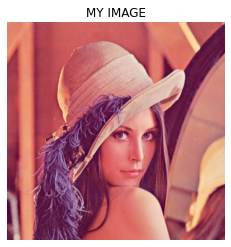

***************************************************************************
[-0.06  0.11  0.12 -0.16 -0.21  0.02 -0.08 -0.08  0.22 -0.12  0.16 -0.02
 -0.27  0.09 -0.07  0.16 -0.2  -0.12 -0.09 -0.12 -0.03  0.14  0.05  0.04
 -0.07 -0.32 -0.05 -0.08  0.04 -0.1   0.07  0.08 -0.16  0.01  0.07  0.13
  0.01 -0.15  0.06 -0.04 -0.19 -0.08  0.1   0.17  0.19 -0.06  0.07 -0.15
  0.14 -0.31  0.04  0.06 -0.    0.07  0.17 -0.25  0.03  0.19 -0.08  0.16
  0.07 -0.03  0.03 -0.04  0.22  0.06 -0.12 -0.24  0.17 -0.15 -0.07  0.2
 -0.1  -0.15 -0.25 -0.03  0.47  0.15 -0.16  0.01 -0.12  0.   -0.01  0.12
 -0.01 -0.03 -0.16  0.02  0.29 -0.04 -0.05  0.31 -0.02  0.04 -0.03  0.11
 -0.16 -0.01 -0.14 -0.1   0.02 -0.05 -0.07  0.14 -0.17  0.13 -0.07  0.
 -0.03 -0.   -0.03  0.    0.26 -0.27  0.17  0.2   0.1   0.15  0.02  0.06
  0.07 -0.11 -0.08 -0.06 -0.06 -0.09 -0.09  0.07]
***************************************************************************


In [13]:
lena_img = img_load("./face_img/lena.png")
lena_emb = get_embedding_raw_img(lena_img)


#시각화======================================
plt.imshow(lena_img)
plt.axis('off')
plt.title("MY IMAGE")
plt.show()
#End========================================


print("*" * 75)
print(np.round(lena_emb, 2))
print("*" * 75)

<br>

### 5.1 평균 임베딩 벡터 도입
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; facebook에는 총 456개의 임베딩 벡터가 있습니다. 기존의 방식은 456개의 임베딩 벡터와 내 이미지의 임베딩 벡터를 서로 대조하여 그중 거리가 가장 가까운 임베딩 벡터를 바탕으로 닮은 유명인을 선정합니다. 하지만 이는 근본적으로 '닮은 유명인'을 찾는 것이 아닌 '닮은 이미지'를 찾는 것 입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 따라서 본 예제에서는 유명인 별로 임베딩의 평균을 구하여 하나의 벡터를 만들고 이를 해당 유명인을 대표하는 벡터로 간주하고자 합니다. 한 유명인의 여러 이미지에 대한 임베딩 벡터의 평균을 구하겠다는 행위의 의미는 '일반화'를 하겠다는 것입니다. 즉, 한 인물에 대한 여러 이미지를 토대로 그 인물의 특징을 판단하는 것입니다. 평균 임베딩 벡터를 도입함으로써 얻을 수 있는 이점은 두 가지 입니다. 첫 번째, 비슷한 이미지를 찾는 것이 아닌 비슷한 인물을 찾을 수 있다는 것입니다. 두 번째, 모든 이미지에 대해 대조하지 않기 때문에 연산에 소모되는 자원이 적다는 것입니다. [img. 1]은 평균 임베딩 벡터를 이용하여 닮은 정도를 구하는 형태를 그림으로 나타낸 것입니다.
</span><br><br>

<img src="img/img1.png" width="600">

[img. 1] 평균 임베딩 벡터를 통한 이미지 대조

***

<br>

#### 평균 임베딩 벡터 구하기
***
+ `get_avg_emb()`는 유명인 별 평균 임베딩 벡터를 구하는 함수입니다.
+ 아래는 'Anna Paquin'에 대한 평균 임베딩 벡터와 기존의 임베딩 벡터를 산점도로 표현한 것입니다.
+ 평균 임베딩 벡터는 선분이 교차하는 지점의 원에 해당합니다.
+ 평균 임베딩 벡터가 주위의 임베딩 벡터를 대표하는 점이라 할 수 있습니다.
***

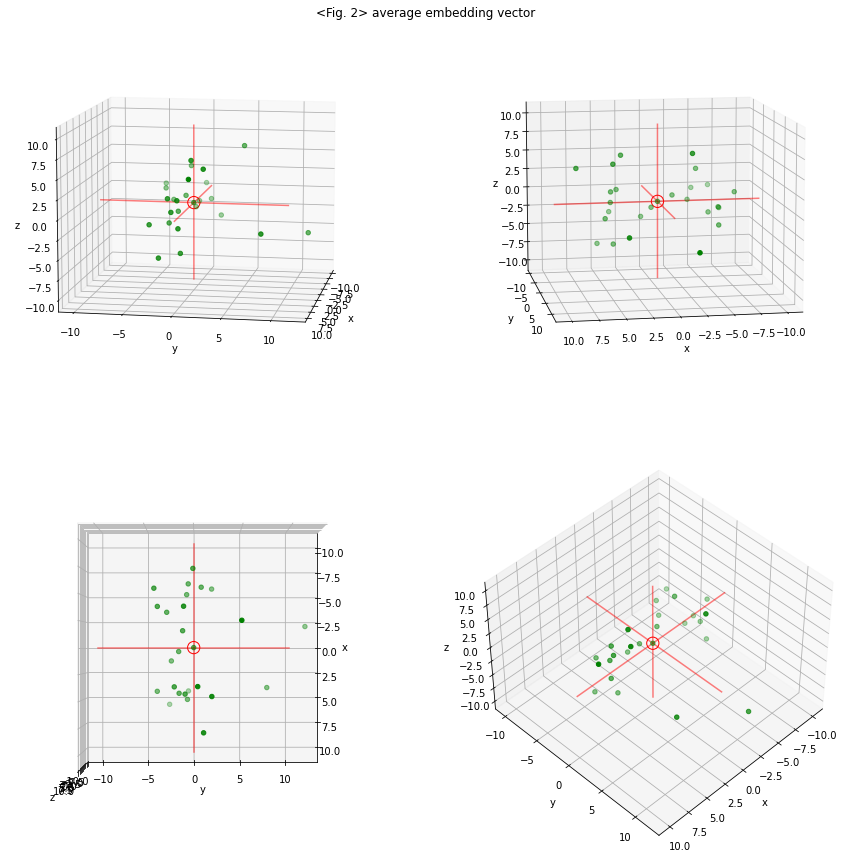

In [14]:
#celeb 별 평균 임베딩 구하기============
def get_avg_emb(facebook):
    emb_book, _ = facebook.get_book()
    avg_emb = {}
    for name, emb_list in emb_book.items():
        mean_emb = np.mean(emb_list, axis=0).tolist()
        avg_emb[name] = mean_emb
    return avg_emb
#End=====================================


avg_emb = get_avg_emb(facebook)["Anna Paquin"]
emb_list = facebook.emb_book["Anna Paquin"].copy()
emb_list.append(avg_emb)

y = ["img"] * (len(emb_list) - 1) + ["avg_vector"]
pca = get_PCA(emb_list, y, 3)

#평균 임베딩 시각화======================
fig = plt.figure(figsize=(15, 15))
plt.title("<Fig. 2> average embedding vector")
plt.axis('off')
angle = [[10, 10], [10, 80], [90, 0], [45, 45]]
for idx, angle in enumerate(angle):
    ax = fig.add_subplot(221 + idx, projection = '3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(angle[0], angle[1])
    ax.scatter(0, 0, 0, s=150, facecolors='none', edgecolors='r')
    ax.scatter(pca[0], pca[1], pca[2], color="green")

    #일차함수
    for idx in range(3):
        input_data = [[0] * 21, [0] * 21, [0] * 21]
        input_data[idx] = np.arange(-10, 11)
        ax.plot(input_data[0], input_data[1], input_data[2], "r", alpha=0.5)
#End=====================================

<br>

### 5.2 내 이미지와 가까운 평균 임베딩 벡터 구하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 각 유명인 별로 평균 임베딩 벡터를 구하였습니다. 이제 내 이미지의 벡터와 대조하여 가까운 유명인을 구할 수 있습니다. lena.png와 유사한 5명의 유명인을 선정하였습니다. 그 결과 'Meg Ryan(0.487)', 'Sarah Chalke(0.61)', 'Julia Roberts(0.64)' 외 2인이 선정 되었습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
     &nbsp; &nbsp; 또한, 해당 인물의 이미지 중 임베딩 거리가 가까운 이미지를 도출하였습니다. 최종적으로 Meg Ryan '2.png'가 0.497, Sarah Chalke '69.png'가 0.609, Julia Roberts 175.png가 0.626의 거리에 있음을 확인하였습니다.
</span>

***

In [15]:
#평균 벡터가 가까운 celeb 구하는 함수================
def get_near_celeb(img, facebook, rank=5):
    input_emb = get_embedding_raw_img(img)   #입력 임베딩
    avg_emb_dic = get_avg_emb(facebook)   #딕셔너리 형태의 celeb 별 평균 임베딩

    distance_list, key_list = [], []
    for name, emb in avg_emb_dic.items():
        distance = get_distance(input_emb, emb)
        distance_list += [distance]
        key_list += [name]

    distance_list, key_list = np.array(distance_list), np.array(key_list)
    sort_list = np.array(distance_list).argsort()[0:rank]   #rank 만큼의 idx
    return [key_list[sort_list].tolist(), distance_list[sort_list].tolist()]
#End==================================================


name_list, celeb_distance_list = get_near_celeb(lena_img, facebook, 5)


print("*" * 75)
for idx, (name, emb) in enumerate(zip(name_list, celeb_distance_list)):  
    print("rnak {0}:\t{1}\tembedding distance: {2}".format(idx, name, round(emb, 3)), end="\n\n")
print("*" * 75)

***************************************************************************
rnak 0:	Meg Ryan	embedding distance: 0.487

rnak 1:	Sarah Chalke	embedding distance: 0.61

rnak 2:	Julia Roberts	embedding distance: 0.64

rnak 3:	Faith Hill	embedding distance: 0.642

rnak 4:	Nicole Richie	embedding distance: 0.653

***************************************************************************


<br>

#### 선정된 유명인의 이미지 중 임베딩 벡터가 가까운 이미지 찾기
***
+ 5명의 닮은 유명인을 구하고 다시 해당 유명인의 이미지 중에서 내 이미지와 거리가 가까운 것을 확인합니다.
***

In [16]:
#평균 벡터가 가까운 celeb 구하는 함수================
def near_celeb_and_file(img, facebook, rank=5):
    input_emb = get_embedding_raw_img(img)   #입력 임베딩
    name_list, celeb_distance_list = get_near_celeb(img, facebook, rank)

    file_name_list, file_distance = [], []
    emb_book, file_name_book = facebook.get_book()
    for name in name_list:
        celeb_emb_list = emb_book[name]
        distance_list = [get_distance(input_emb, emb) for emb in celeb_emb_list]
        max_idx = np.argmin(distance_list)

        near_file_name = file_name_book[name][max_idx]   #이미지 이름
        near_file_distance = distance_list[max_idx]   #이미지 임베딩 거리

        file_name_list += [near_file_name]
        file_distance += [near_file_distance]
    return [name_list, celeb_distance_list, file_name_list, file_distance]
#End==================================================

name_list, celeb_distance_list, file_name_list, file_distance = near_celeb_and_file(lena_img, facebook, 5)

print("*" * 75)
for idx, (celeb_name, celeb_emb, file_name, file_emb) in enumerate(zip(
    name_list, celeb_distance_list, file_name_list, file_distance
)):
    print("rnak {0}:\t{1}\tembedding distance: {2}".format(idx, celeb_name, round(celeb_emb, 3)))
    print("\t└\"{0}\" imbedding distance: {1}".format(file_name, round(file_emb, 3)), end="\n\n")
    
print("*" * 75)

***************************************************************************
rnak 0:	Meg Ryan	embedding distance: 0.487
	└"2.png" imbedding distance: 0.479

rnak 1:	Sarah Chalke	embedding distance: 0.61
	└"69.png" imbedding distance: 0.609

rnak 2:	Julia Roberts	embedding distance: 0.64
	└"175.png" imbedding distance: 0.626

rnak 3:	Faith Hill	embedding distance: 0.642
	└"2.png" imbedding distance: 0.612

rnak 4:	Nicole Richie	embedding distance: 0.653
	└"250.png" imbedding distance: 0.637

***************************************************************************


<br>

#### 선정된 이미지 출력하기
****
+ lena.png와 닮은 5명의 이미지를 출력합니다.
****

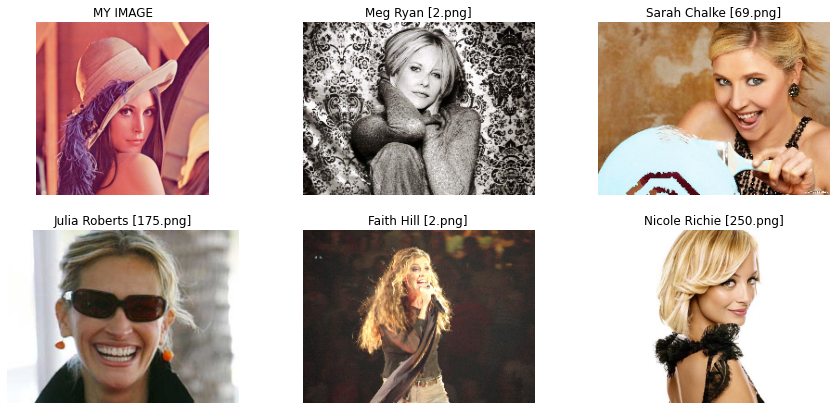

In [17]:
img_list = [lena_img] + [
    img_load("./face_img/dataset/" + celeb_name + "/" + file_name) \
    for celeb_name, file_name in zip(name_list, file_name_list)
]
celeb_name_list = ["MY IMAGE"] + [
    celeb_name + " [" + file_name + "]" \
    for celeb_name, file_name in zip(name_list, file_name_list)
]

row, col = 2, 3
plt.figure(figsize=(15, 7))
for idx, img in enumerate(img_list):
    plt.subplot(row, col, idx + 1)
    plt.title(celeb_name_list[idx])
    plt.imshow(img)
    plt.axis("off")
plt.show()

<br>

#### 인물 간 거리 시각화 하기
***
+ 선정된 5인의 평균 임베딩 벡터와 lena.png의 임베딩 벡터를 2차원으로 축소시켜 시각화 하였습니다.
+ 차원축소는 t-SNE를 이용하였습니다.
***

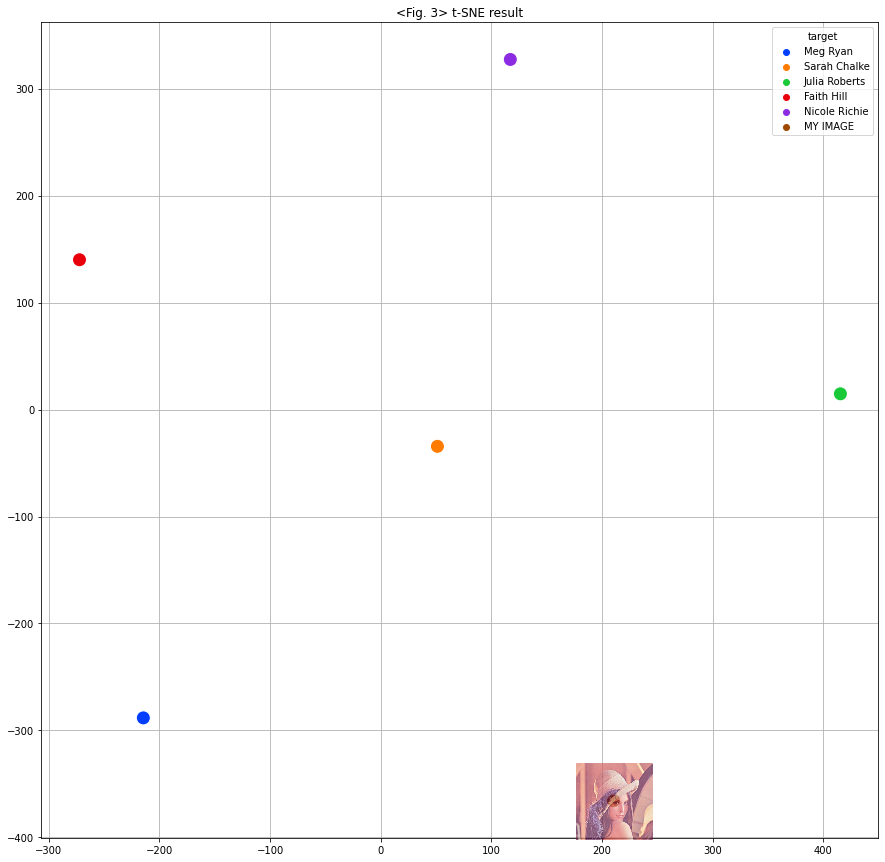

In [35]:
visual_emb_list, visual_name_list = [], []

# #평균 임베딩 벡터
visual_emb_list += [get_avg_emb(facebook)[name] for name in name_list]
# visual_name_list += ["AVG_vector"] * len(visual_emb_list)
visual_name_list += name_list

#my_img 임베딩 벡터
visual_emb_list += [get_embedding_raw_img(img)]
visual_name_list += ["MY IMAGE"]
        

#t-sne==============================
from sklearn.manifold import TSNE
def get_TSNE(X, Y, dim):
    tsne = TSNE(n_components=dim)
    result = tsne.fit_transform(X)
    result = pd.DataFrame(result)
    result["target"] = Y
    return result
#End=================================

tsne = get_TSNE(visual_emb_list, visual_name_list, 2)

#시각화==============================
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("<Fig. 3> t-SNE result")

sns.scatterplot(x=tsne[0], y=tsne[1], hue=tsne["target"], s=200, palette=sns.color_palette("bright", n_colors=6))

imagebox = OffsetImage(lena_img, zoom = 0.15, alpha=0.7)
ab = AnnotationBbox(imagebox, (tsne.iloc[-1][0]+1, tsne.iloc[-1][1]-1), frameon = False)
ax.add_artist(ab)

plt.xlabel("")
plt.ylabel("")
plt.grid(True)

plt.show()
#End=================================

<br><br>

## 6 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 유명인 이미지 데이터셋으로부터 얼굴의 임베딩 벡터를 수집하여 내 이미지의 임베딩 벡터와 거리를 토대로 닮은 유명인을 도출하였습니다. 특히, 이미지를 모두 대조하여 닮은 이미지를 구한 후, 이미지가 누구인지를 출력하는 방식이 아닌, 유명인 별 평균 임베딩 벡터를 구하여 해당 벡터를 대표로 하여 이를 내 이미지의 임베딩 벡터와 비교하였습니다. 해당 방식을 통해 '일반화'와 '연산 효율성'을 얻을 수 있음을 알았습니다. 또한, PCA와 t-SNE를 사용하여 128 크기의 벡터를 2, 3차원으로 축소하여 데이터를 시각화 하였습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; lena.png와 60명의 유명인의 임베딩 벡터의 거리를 구한 결과, Meg Ryan '2.png', Sarah Chalke '69.png', Julia Roberts 175.png'가 0.497, 0.609, 0.626 순의 거리에 있음을 확인하였습니다. [표 1]은 lena.png에 대한 유명인 5인의 임베딩 벡터 거리를 제시한 것입니다.
</span><br><br>


|Celeb Name|File Name|Distance|
|:--------:|:--------:|:--------:|
|**Meg Ryan**|2.png|0.479|
|**Sarah Chalke**|69.png|0.609|
|**Julia Roberts**|175.png|0.626|
|**Faith Hill**|22.png|0.612|
|**Nicole Richie**|250.png|0.637|

[표 1] lena.png에 대한 top 5 유명인 임베딩 정보
***

#### 형상관리
***
+ v1_1: 초기버전


+ v2_1: 양식 및 내용 작성


+ v3_1: 내용 수정 및 추가
***

##### 회고
***
본 예제를 진행하면서 다음과 같은 궁금증이 생겼습니다. 첫 번째는, '그럼 가위, 바위, 보도 임베딩 벡터를 이용하여 분류한 후, 테스트 이미지를 넣음으로써 그 거리를 알고 가위, 바위, 보를 분류 할 수 있지 않을까'였습니다. 두 번째는 축소된 임베딩 벡터를 토대로 다시 원본 이미지로 복구 할 수 있을까'였습니다.

우선 첫 번째에 대한 대답은, dlib가 출력하는 임베딩 벡터는 얼굴에 한해서 출력하기 때문에 바로 가위, 바위, 보를 적용하긴 어렵다는 것이었습니다. 하지만, 가위, 바위, 보에 대한 이미지로 분류 신경망을 학습하여, 축소된 중간층을 임베딩 벡터로 사용하면 되지 않을까싶습니다. 두 번째에 대한 답은 앞의 질문과 반대로 신경망에 임베딩 벡터를 넣어줌으로써 가능하지 않을까 싶습니다. 축소된 임베딩으로부터 원본 이미지를 구현하는 것은 결국 디코더에 해당하기 때문입니다.

마지막으로 lena.png와 비슷한 인물들이 도출되서 상당히 신기했습니다. 해당 5명의 유명인들 모두 다른 사람들임에도 불구하고 서로 동일인물이라고 생각 될 정도로 비슷한 것 같습니다.
***